Check Data Distribution: Ensure the dataset is balanced among the categories. A skewed distribution can cause the model to predict the most frequent class.
Increase Dropout: To help with overfitting, especially given your issue with converging on a single class.
Modify the Transformer Setup: Adjust parameters like the number of heads and layers, especially if your model complexity doesn't match the task complexity.
Learning Rate Scheduler: Implement a scheduler to adjust the learning rate during training, which can help in better convergence.
Model Regularization: Consider adding batch normalization layers to stabilize the learning process.
Increase Epochs: As suggested by your TA, increasing the number of training epochs might help, but first ensure that the model architecture and learning rate are optimally set.

In [4]:
from socket import gethostname
gethostname()

'hpc3-gpu-24-01'

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [6]:
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model and move it to device
class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Increased percentage dropped to combat overfitting
            nn.Dropout(0.5)
        )
        self.output_layer = nn.Linear(256*3*3, 7)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 256*3*3)
        x = self.output_layer(x)
        return x

# Initialize model, optimizer, loss function, and scheduler
model = FERModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# scheduler = ExponentialLR(optimizer, gamma=0.95)

# Lists to store metrics
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_acc.append(correct / total)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_acc.append(correct / total)


    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {train_acc[-1]}, Val Acc: {val_acc[-1]}')



Using device: cuda


Epoch 1/15:   1%|█▏                                                                                                      | 10/898 [00:00<00:38, 22.84it/s]

Epoch 1/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:34<00:00, 25.94it/s]


Epoch 1, Train Loss: 1.766083275401076, Val Loss: 1.4486231304005548, Train Acc: 0.34041589745376016, Val Acc: 0.43772638617999443


Epoch 2/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:33<00:00, 26.82it/s]


Epoch 2, Train Loss: 1.4555555987521696, Val Loss: 1.3671974939501494, Train Acc: 0.44442509317635587, Val Acc: 0.48746168849261634


Epoch 3/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:38<00:00, 23.23it/s]


Epoch 3, Train Loss: 1.32982688378821, Val Loss: 1.2297007891088185, Train Acc: 0.4939914312584904, Val Acc: 0.5352465867929785


Epoch 4/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:36<00:00, 24.88it/s]


Epoch 4, Train Loss: 1.255884961161088, Val Loss: 1.1746249354111513, Train Acc: 0.5211606116548817, Val Acc: 0.5530788520479242


Epoch 5/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:34<00:00, 25.80it/s]


Epoch 5, Train Loss: 1.2005121464506578, Val Loss: 1.1897836477353267, Train Acc: 0.5442544149918144, Val Acc: 0.5433268319866258


Epoch 6/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:34<00:00, 25.76it/s]


Epoch 6, Train Loss: 1.1578164094210859, Val Loss: 1.1230087318636972, Train Acc: 0.5640043192030374, Val Acc: 0.5774589022011702


Epoch 7/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:33<00:00, 26.95it/s]


Epoch 7, Train Loss: 1.1272244872068253, Val Loss: 1.0927175113370273, Train Acc: 0.5739663520150475, Val Acc: 0.5869322931178601


Epoch 8/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:32<00:00, 27.62it/s]


Epoch 8, Train Loss: 1.0960155133522724, Val Loss: 1.0910953571783795, Train Acc: 0.5860531540631858, Val Acc: 0.5923655614377263


Epoch 9/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:35<00:00, 25.52it/s]


Epoch 9, Train Loss: 1.0592275030448763, Val Loss: 1.0892410709121227, Train Acc: 0.6047929220801839, Val Acc: 0.5962663694622458


Epoch 10/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:34<00:00, 26.25it/s]


Epoch 10, Train Loss: 1.0350092411136764, Val Loss: 1.0612652942177045, Train Acc: 0.6130481730467797, Val Acc: 0.6095012538311507


Epoch 11/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:32<00:00, 27.88it/s]


Epoch 11, Train Loss: 1.0121209613581537, Val Loss: 1.0342587327751218, Train Acc: 0.6205719460796266, Val Acc: 0.6177208135971023


Epoch 12/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:32<00:00, 27.93it/s]


Epoch 12, Train Loss: 0.9857078206971411, Val Loss: 1.0317501718867088, Train Acc: 0.6348880142115713, Val Acc: 0.6220395653385344


Epoch 13/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:32<00:00, 27.87it/s]


Epoch 13, Train Loss: 0.9648455219182597, Val Loss: 1.033222730294613, Train Acc: 0.6429342714828102, Val Acc: 0.6159097241571468


Epoch 14/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:32<00:00, 27.82it/s]


Epoch 14, Train Loss: 0.9428401965200393, Val Loss: 1.0183060195044775, Train Acc: 0.6476366296283396, Val Acc: 0.6256617442184452


Epoch 15/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:31<00:00, 28.21it/s]


Epoch 15, Train Loss: 0.922789068069074, Val Loss: 1.0574481441603294, Train Acc: 0.6565188616810059, Val Acc: 0.6067149623850655


In [14]:
print(model)

FERModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_loader is your DataLoader for the test dataset
true_labels = []
predicted_labels = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average="weighted")
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Overall Accuracy: 0.6067
F1 Score: 0.5887


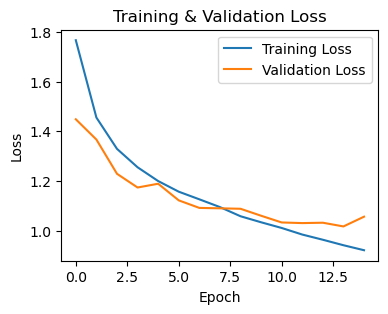

In [13]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

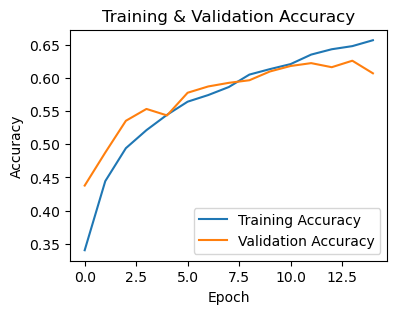

In [12]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

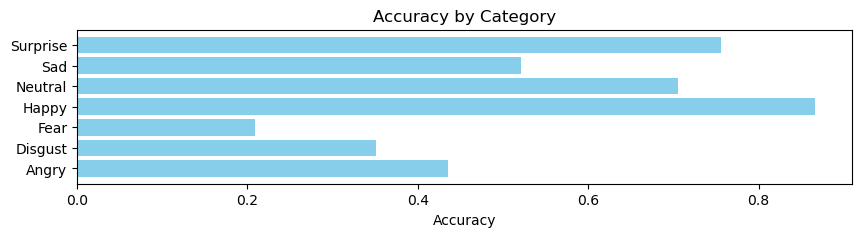

In [10]:
import numpy as np

category_accuracies = []
for i in range(7):
    category_mask = (np.array(true_labels) == i)
    category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
    category_accuracies.append(category_acc)

# Plotting category accuracies
categories = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
ax.barh(range(7), category_accuracies, color='skyblue')
ax.set_xlabel('Accuracy')
ax.set_yticks(range(7))
ax.set_yticklabels(categories)
ax.set_title('Accuracy by Category')
plt.show()

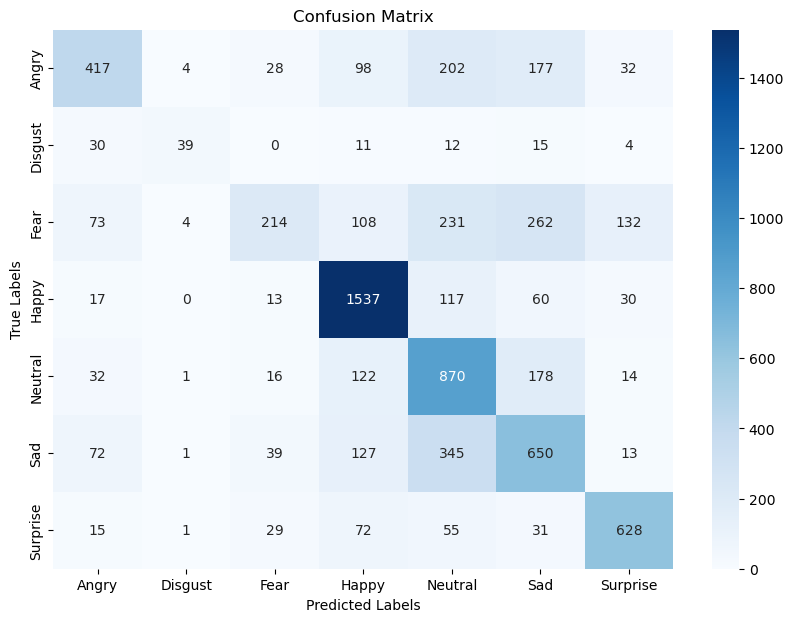

In [11]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
